# To Do

- Visualizations for interference pattern
- Clean up graphs (Julie plots look nicer atm)
- high circuit depths in problem 3 creating Nans, figure out where, might be precision error from gates constants being multiplied several times, currently run at lower depth
- 2 qubit probability not coming out correctly in problem 4

# Cohort Project 2021: Trapped Ions

In [243]:
import cirq
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

%matplotlib inline


#Set Figure Sizes
plt.rcParams["figure.figsize"] = (20,10)

# Functions

In [315]:
class r_gate(cirq.Gate):
    """Rotation gate."""
    def __init__(self, theta, phi):
        super(r_gate, self)
        self.theta = theta
        self.phi = phi
        

    def _num_qubits_(self):
        return 1

    def _unitary_(self):
        return np.array([
            [np.cos(self.theta / 2), -1j * np.exp(-1j * self.phi) * np.sin(self.theta / 2)],
            [-1j * np.exp(1j * self.phi) * np.sin(self.theta / 2), -np.cos(self.theta / 2)]
        ])

    def _circuit_diagram_info_(self, args):
        return f"R({self.theta},{self.phi})"


class m_gate(cirq.TwoQubitGate):
    """M gate"""
    def __init__(self, Theta):
        super(m_gate, self)
        self.Theta = Theta

    def _unitary_(self):
        return np.array([
            [1.0 * np.cos(self.Theta), 0.0, 0.0, -1j * np.sin(self.Theta)],
            [0.0, 1.0 * np.cos(self.Theta), -1j * np.sin(self.Theta), 0.0],
            [0.0, -1j * np.sin(self.Theta), 1.0 * np.cos(self.Theta), 0.0],
            [-1j * np.sin(self.Theta), 0.0, 0.0, 1.0 * np.cos(self.Theta)]])

    def _circuit_diagram_info_(self, args):
        return f"M_rot({self.Theta})", f"M_rot({self.Theta})"


    
    
    
def run(N, depth, num_samples, noise=False,del_Theta=0):
    qreg = [cirq.LineQubit(i) for i in range(N)]
    circuit = cirq.Circuit()

    for i in range(depth):
        for j in range(N):
            # random single-bit gate
            theta = 2 * np.pi * np.random.rand()
            phi = 2 * np.pi * np.random.rand()
            R_gate = r_gate(theta=theta, phi=phi)
            # circuit.append(cirq.XPowGate(exponent=theta, global_shift=phi)(qreg[x]))
            circuit.append(R_gate(qreg[j]))

        # Alternate start qubit for pairs.
        idx_first = i % 2
        
        for j in np.arange(idx_first, N - 1, 2):
            Theta = 2 * np.pi * np.random.rand()
            M_gate = m_gate(Theta=2 * np.pi * np.random.rand())
            circuit.append(M_gate(qreg[j], qreg[j + 1]))

    circuit.append([cirq.measure(qreg[i]) for i in range(N)])
    # add noise gate
    if noise ==True:
        circuit.insert(np.random.randint(0, len(circuit)),
                       cirq.X(qreg[np.random.randint(0, N)]))
    # print('Circuit:')
    # print(circuit)

    sim = cirq.Simulator()

    result = sim.run(circuit, repetitions=num_samples)

    return qreg, circuit, result

def Prob_X(result,bit_string,num_samples):
    num_states = pow(2,N)
    agg =result.data.groupby(result.data.columns.tolist(),as_index=False).size()
    agg['probability']= agg['size']/num_samples
    agg['bit_string'] = ''
    for row in range(agg.shape[0]):
        for col in range(agg.shape[1]-3):
            agg.iloc[row,N+2] +=str(agg.iloc[row,col])
    agg_row = agg[agg['bit_string']==bit_string]
    if len(agg_row['probability'].values) ==0:
        return 0
    return agg_row['probability'].values[0]

#Cross Entropy
def XEB(P_dist,N,sample_size):
    return (pow(2,N))*sum(P_dist)-1

# Task 1

## A Single Circuit

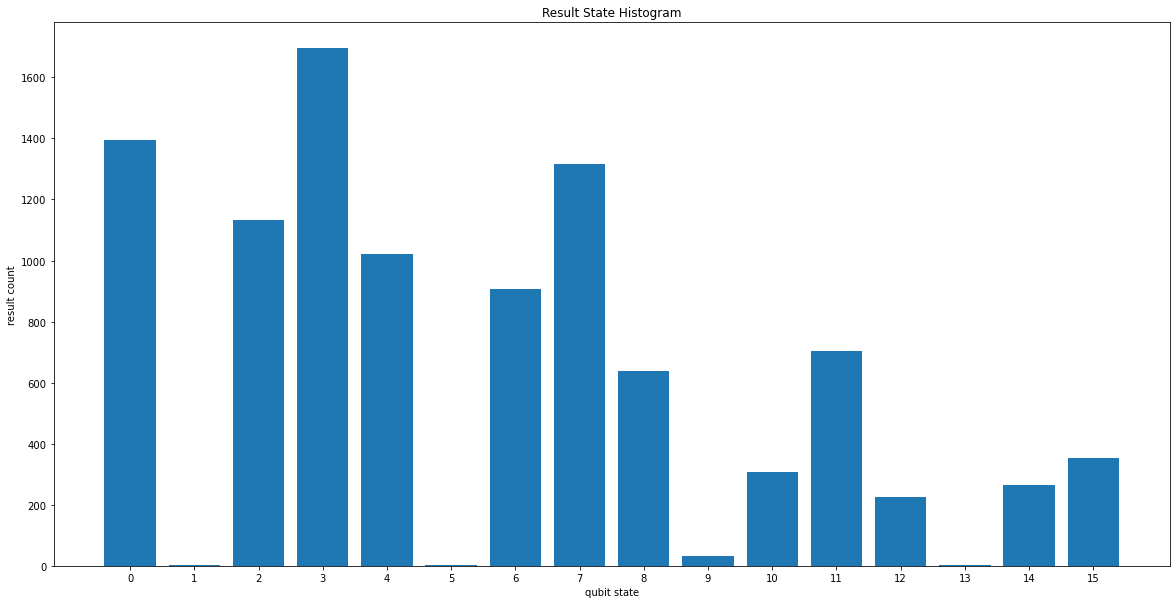

In [182]:
# basic run of the random circuitnp.random.seed(123)
N = 4
depth = 3
num_samples=10000

qreg, circuit, result = run(N, depth,num_samples)
_ = cirq.vis.plot_state_histogram(result)

## Outputing probability 

In [183]:
bit_string = '1001'
Prob_X(result,bit_string,num_samples)

0.0031

## Interference Visualization

# Task 2

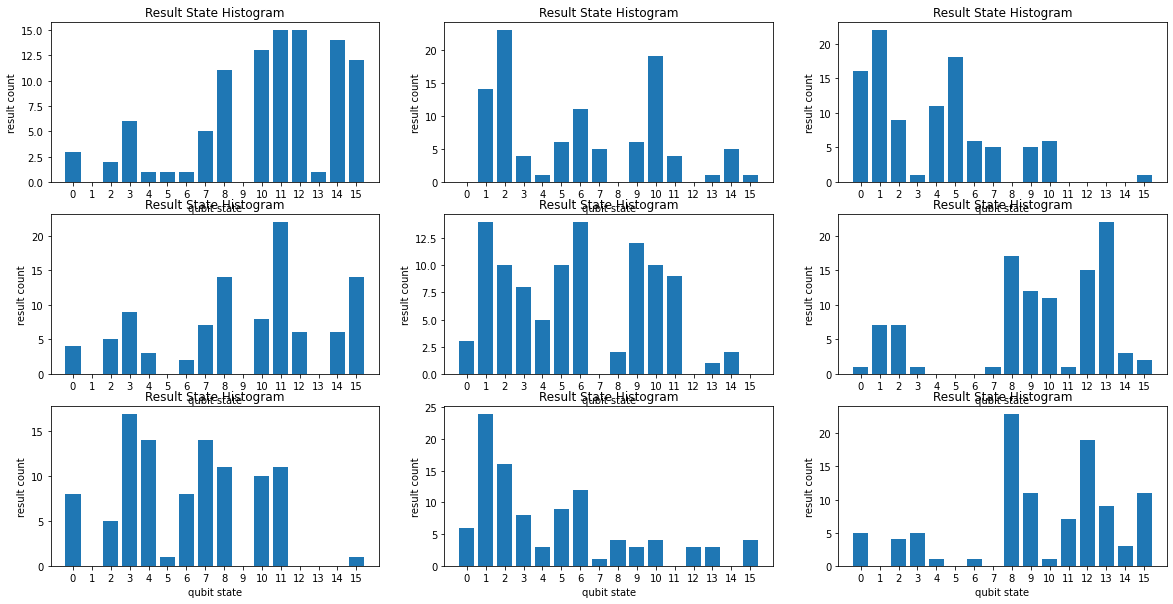

In [184]:
# Add sigma_x randomly and run of the random circuit
n_sims = 9
N = 4
depth = 3
n_pl = int(np.ceil(np.sqrt(n_sims)))
fig, ax = plt.subplots(n_pl, n_pl)

for x in range(n_sims):
    i = x % n_pl
    j = int(np.floor(x / n_pl))

    circuit.insert(np.random.randint(0, len(circuit)),
                   cirq.X(qreg[np.random.randint(0, N)]))

    sim = cirq.Simulator()
    result = sim.run(circuit, repetitions=100)

    # result = run(N, depth, sigma_x=True)
    _ = cirq.vis.plot_state_histogram(result, ax[i,j])



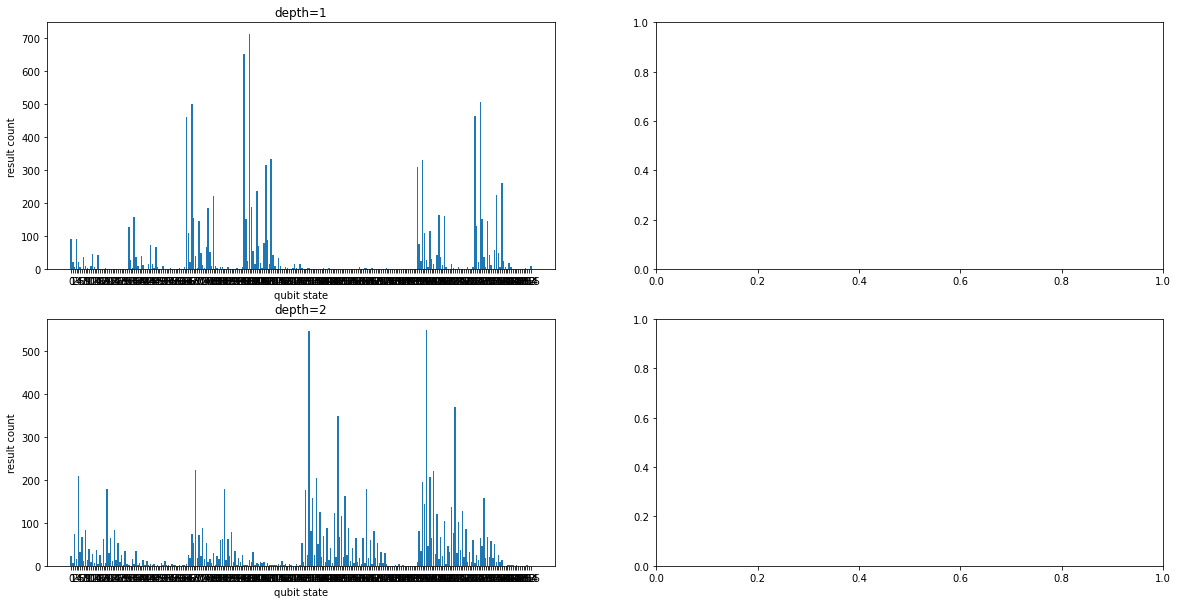

In [188]:
# Test different depths
N = 8
depths = [2**n for n in range(2)]
n_sims = len(depths)
n_pl = int(np.ceil(np.sqrt(n_sims)))
fig2, ax2 = plt.subplots(n_pl, n_pl)

for x in range(n_sims):
    np.random.seed(123)
    i = x % n_pl
    j = int(np.floor(x / n_pl))

    qreg, circuit, result = run(N, depths[x],num_samples)
    _ = cirq.vis.plot_state_histogram(result, ax2[i, j], title=f"depth={depths[x]}")

# Task 3  --- returning nans on high depth from gate precision??

In [279]:
#N = 8, depths = 512

N = 8
depth = 60
num_samples = 5000
runs =1000
bit_string = '10100000'


P_dist =[]

# Loop over num of runs calculating p and add it to distribution set
#add a random bitflip each time to simulate noise
for i in range(runs):
    qreg, circuit, result = run(N, depth,num_samples,noise = True)

    P_dist.append(Prob_X(result,bit_string,num_samples))
#Sort it
P_dist.sort()




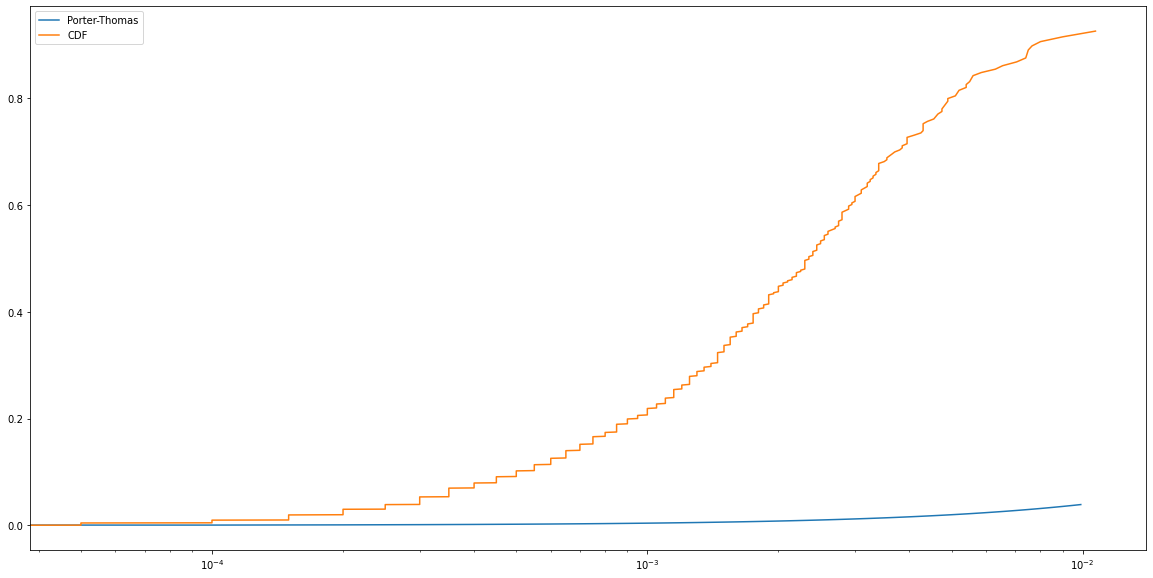

In [295]:
# plotting Porter-Thomas Distribution and CDF
data = P_dist
data = [i/pow(2,N) for i in data]
data2=[0.0001*i for i in range(100)]

cdf = np.cumsum(data)


plt.semilogx()
plt.plot(data2,[(1-np.exp(-pow(2,N)*p)) for p in data2],label ='Porter-Thomas')

plt.plot(data, cdf, label="CDF")
plt.legend()


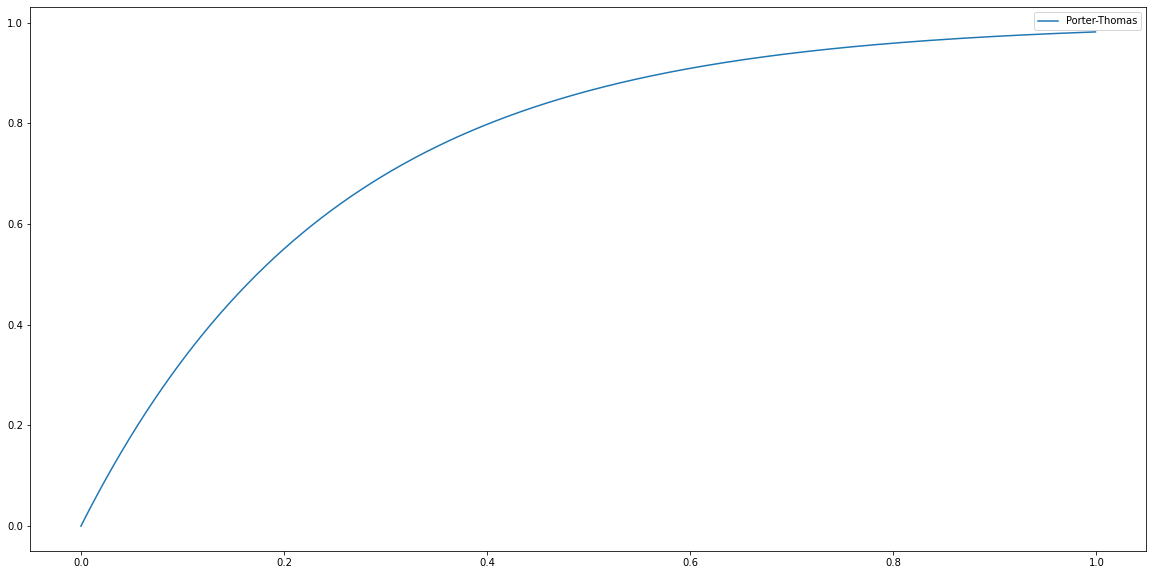

In [291]:
N = 2

data = P_dist
data2=[0.001*i for i in range(1000)]

cdf = np.cumsum(data)

# plotting Porter-Thomas Distribution and CDF

plt.plot(data2,[(1-np.exp(-pow(2,N)*p)) for p in data2],label ='Porter-Thomas')

plt.legend()

# Task 4

https://quantumai.google/cirq/qcvv/xeb_theory

In [321]:
# Run several times varying Big Theta and plot F_XEB vs del_Theta

N = 2
depth = 10
num_samples = 100

XEBs =[]
del_Thetas=[]

#Loop over sets of del_Theta
del_Theta = 0
for i in range(100):
    del_Theta+=3.14/100
    del_Thetas.append(del_Theta)
    #Loop over all bitstring combinations
    P_dist = []
    for bstring in ['00','01','10','11']:
        qreg, circuit, result = run(N, depth,num_samples,del_Theta)
        print(Prob_X(result,bit_string,num_samples))
        P_dist.append( Prob_X(result,bit_string,num_samples))
    XEBs.append(XEB(P_dist,N,num_samples))


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1] [0.031400000000000004, 0.06280000000000001, 0.0942, 0.12560000000000002, 0.15700000000000003, 0.18840000000000004, 0.21980000000000005, 0.25120000000000003, 0.2826, 0.314, 0.3454, 0.37679999999999997, 0.40819999999999995, 0.43959999999999994, 0.4709999999999999, 0.5024, 0.5337999999999999, 0.5651999999999999, 0.5965999999999999, 0.6279999999999999, 0.6593999999999999, 0.6907999999999999, 0.7221999999999998, 0.7535999999999998, 0.7849999999999998, 0.8163999999999998, 0.8477999999999998, 0.8791999999999998, 0.9105999999999997, 0.9419999999999997, 0.9733999999999997, 1.0047999999999997, 1.036199

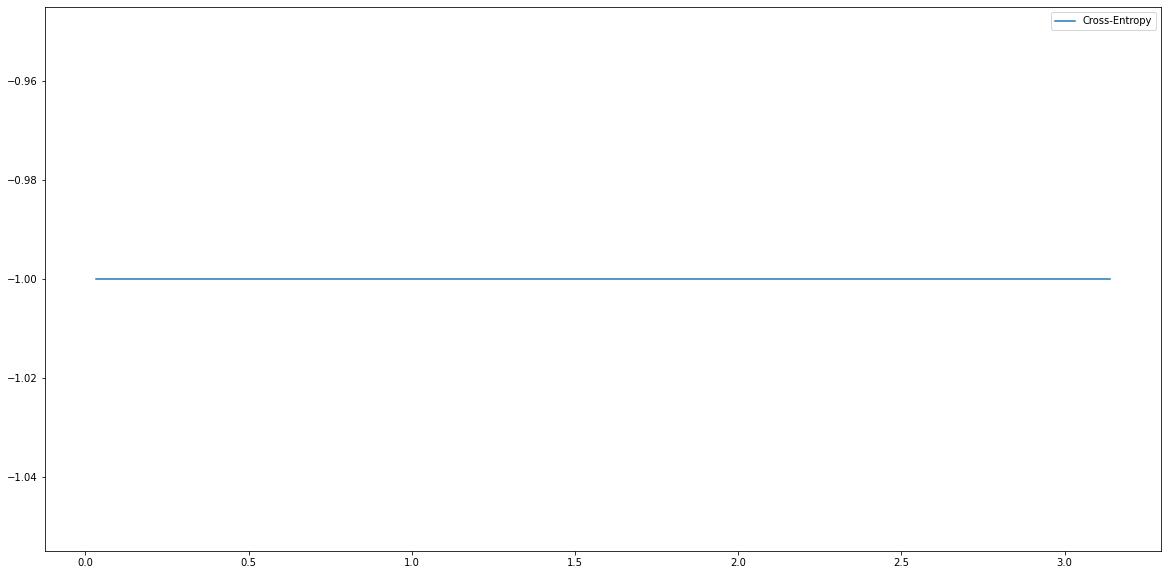

In [317]:
#Plot  F_XEB vs delta Theta
print((XEBs),(del_Thetas))
plt.plot(del_Thetas,XEBs,label ='Cross-Entropy')

plt.legend()